In [1]:
import pennylane as qml
from pennylane import numpy as np

In [8]:
wires = 3
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.RZ(params[2], wires=2)

    qml.broadcast(qml.CNOT, wires=range(wires), pattern="ring")
    
    qml.RX(params[3], wires=0)
    qml.RY(params[4], wires=1)
    qml.RZ(params[5], wires=2)

    qml.broadcast(qml.CNOT, wires=range(wires), pattern="ring")

    return qml.expval(qml.PauliY(0)@qml.PauliZ(2))

(<Figure size 1100x400 with 1 Axes>, <Axes: >)

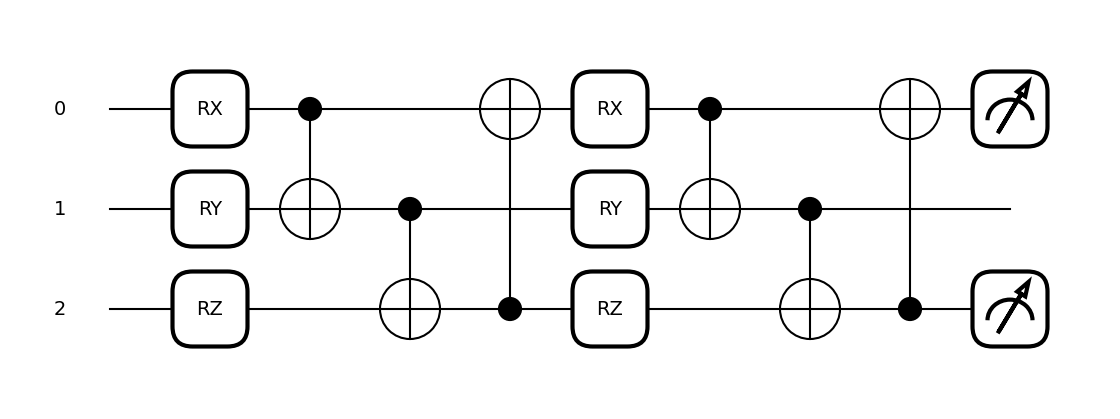

In [9]:
params = 0.05 * np.random.randn(6)
qml.draw_mpl(circuit)(params)

In [14]:
def one_param_shift(params, index=0):
    back_param = params.copy()
    front_param = params.copy()
    back_param[index] -= np.pi / 2
    front_param[index] += np.pi / 2
    back = circuit(back_param)
    front = circuit(front_param)
    return 0.5 * (front - back)

def parameter_shift(params):
    gradients = np.zeros(6)
    for i in range(6):
        gradients[i] = one_param_shift(params, i)
    return gradients

In [16]:
grad_fn = qml.grad(circuit)
print(grad_fn(params))
print(parameter_shift(params))
print(qml.gradients.param_shift(circuit)(params))

[-3.47725930e-05 -5.75390434e-03  0.00000000e+00  7.57367063e-02
 -2.96056626e-02  2.16840434e-19]
[-3.47725930e-05 -5.75390434e-03  0.00000000e+00  7.57367063e-02
 -2.96056626e-02  2.16840434e-19]
(array(-3.4772593e-05), array(-0.0057539), array(0.), array(0.07573671), array(-0.02960566), array(2.16840434e-19))


In [26]:
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift")
def circuit(params):
    qml.StronglyEntanglingLayers(params, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3))

param_shape = qml.StronglyEntanglingLayers.shape(n_wires=4, n_layers=4)
params = np.random.normal(scale=0.1, size=param_shape, requires_grad=True)

print(param_shape)

print(qml.draw(circuit,expansion_strategy="device")(params))

(4, 4, 3)
0: ──Rot(-0.06,0.10,0.03)──╭●───────╭X──Rot(0.11,0.08,-0.08)──╭●────╭X──Rot(-0.17,0.10,0.02)
1: ──Rot(-0.01,-0.00,0.13)─╰X─╭●────│───Rot(0.06,-0.00,-0.25)─│──╭●─│──╭X───────────────────
2: ──Rot(0.06,-0.14,0.08)─────╰X─╭●─│───Rot(0.01,-0.10,-0.07)─╰X─│──╰●─│────────────────────
3: ──Rot(-0.17,0.16,0.15)────────╰X─╰●──Rot(0.05,0.08,-0.05)─────╰X────╰●───────────────────

─────────────────────────╭●─╭X──Rot(-0.09,-0.11,-0.09)───────────────────────
───Rot(-0.03,0.01,-0.02)─│──╰●─╭X───────────────────────Rot(-0.01,-0.15,0.01)
───Rot(-0.03,0.01,-0.01)─│─────╰●──────────────────────╭X────────────────────
───Rot(-0.18,0.07,0.06)──╰X────────────────────────────╰●────────────────────

──╭●────────────────────────────╭X─┤ ╭<Z@Z@Z@Z>
──╰X──────────────────────╭●────│──┤ ├<Z@Z@Z@Z>
───Rot(-0.10,0.04,0.16)───╰X─╭●─│──┤ ├<Z@Z@Z@Z>
───Rot(-0.01,-0.03,-0.11)────╰X─╰●─┤ ╰<Z@Z@Z@Z>
